In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import kaggle_evaluation.jane_street_inference_server

# Load Data

In [3]:
features_data = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv')
responders_data = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')
sample_data = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv')
train_data = pl.scan_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet").filter(pl.col("partition_id") == 0).collect()


In [4]:
print(features_data.dtypes)
print(responders_data.dtypes)
print(sample_data.dtypes)
#check data types

feature    object
tag_0        bool
tag_1        bool
tag_2        bool
tag_3        bool
tag_4        bool
tag_5        bool
tag_6        bool
tag_7        bool
tag_8        bool
tag_9        bool
tag_10       bool
tag_11       bool
tag_12       bool
tag_13       bool
tag_14       bool
tag_15       bool
tag_16       bool
dtype: object
responder    object
tag_0          bool
tag_1          bool
tag_2          bool
tag_3          bool
tag_4          bool
dtype: object
row_id           int64
responder_6    float64
dtype: object


In [5]:
# encoding
labelencoder = LabelEncoder()
features_data['feature'] = labelencoder.fit_transform(features_data['feature'])
responders_data['responder'] = labelencoder.fit_transform(responders_data['responder'])

# Exploratory Data Analysis(EDA)


Features Dataset Shape: (79, 18)

Missing Values:
 feature    0
tag_0      0
tag_15     0
tag_14     0
tag_13     0
tag_12     0
tag_11     0
tag_10     0
tag_9      0
tag_8      0
tag_7      0
tag_6      0
tag_5      0
tag_4      0
tag_3      0
tag_2      0
tag_1      0
tag_16     0
dtype: int64

Summary Statistics:
          feature
count  79.000000
mean   39.000000
std    22.949219
min     0.000000
25%    19.500000
50%    39.000000
75%    58.500000
max    78.000000


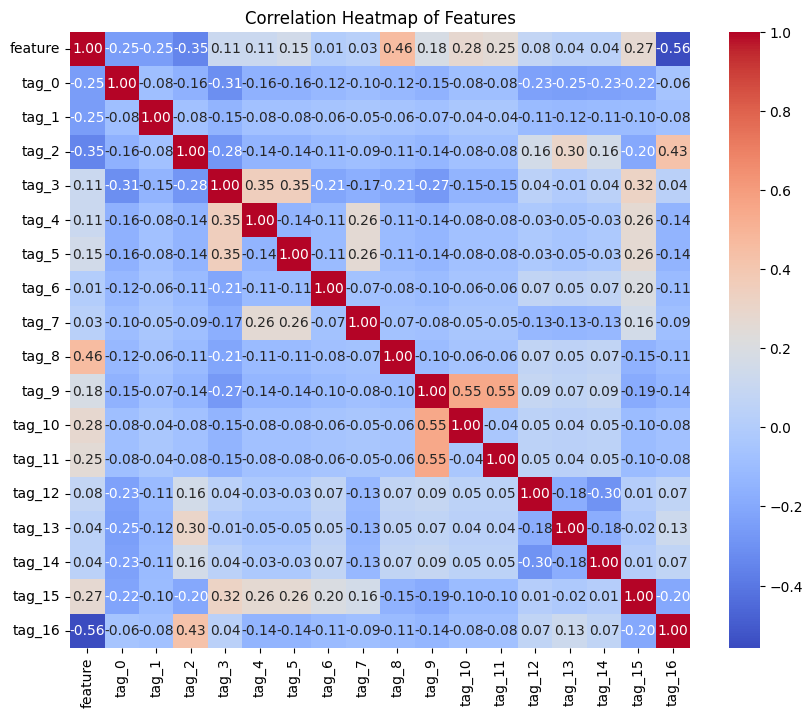

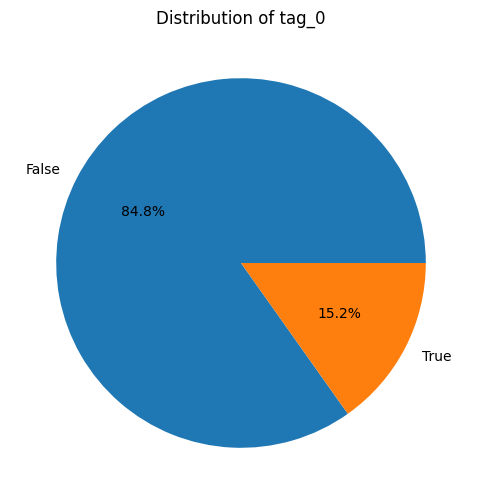

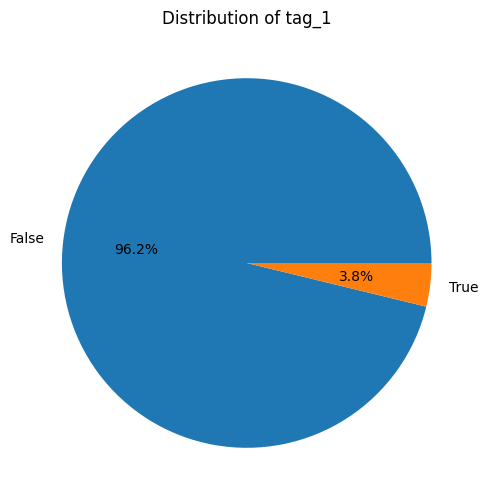

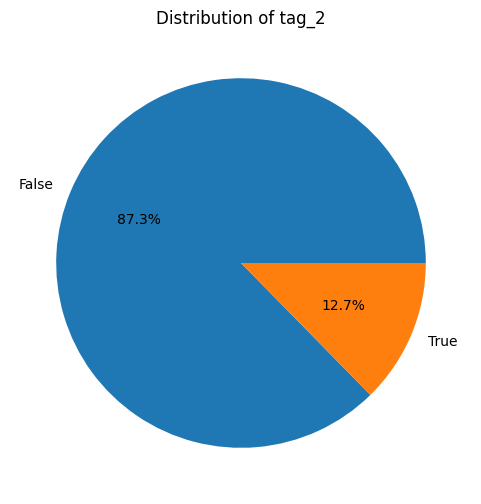

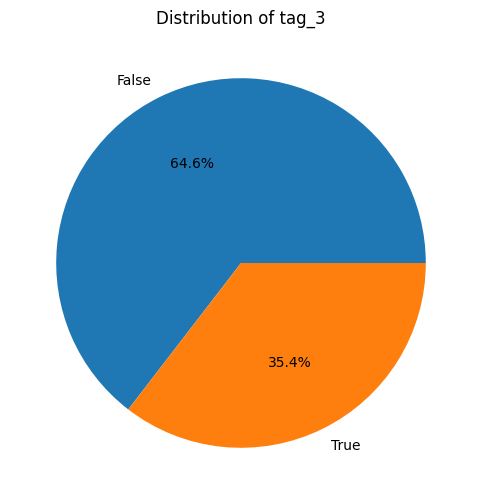

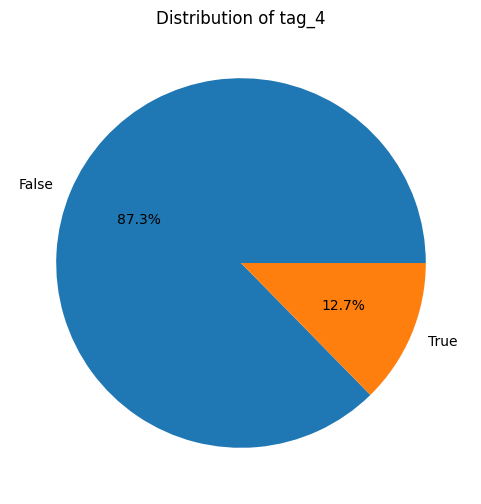

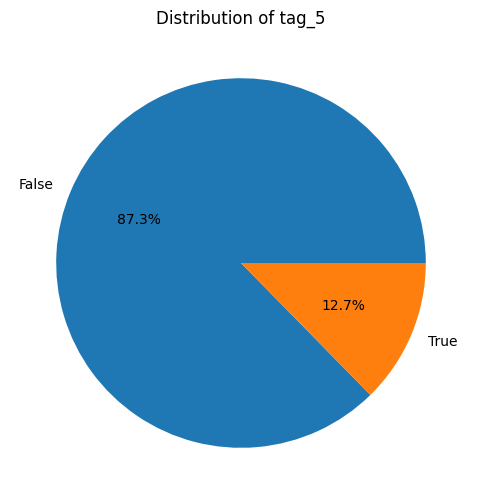

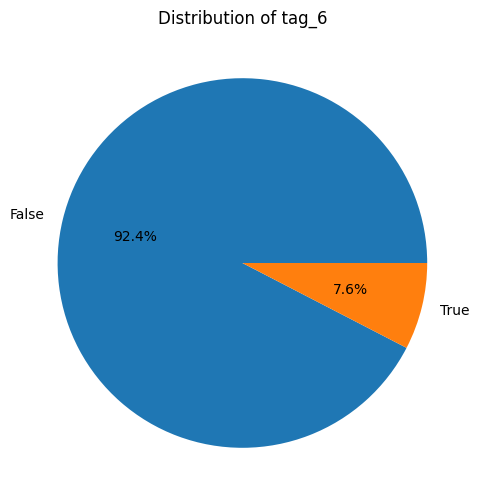

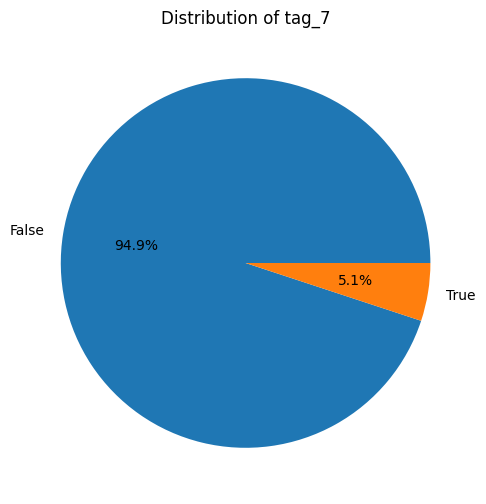

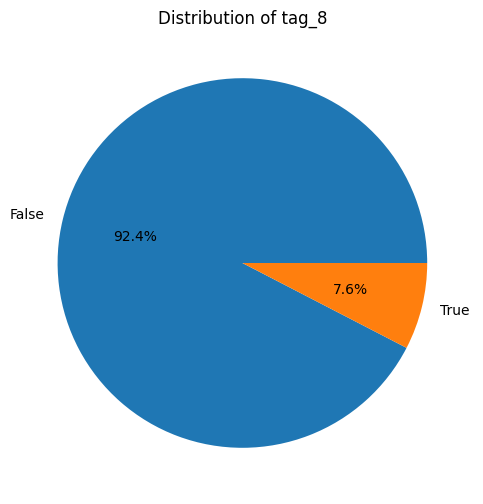

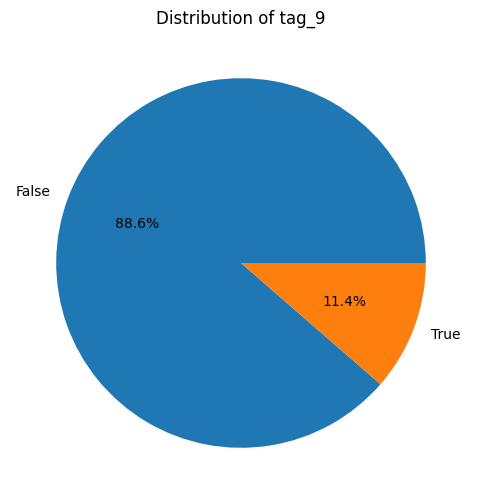

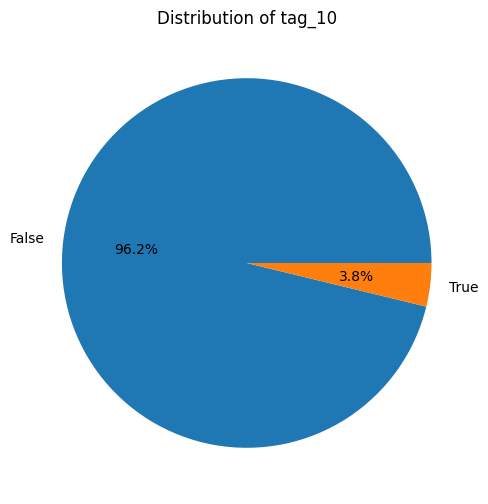

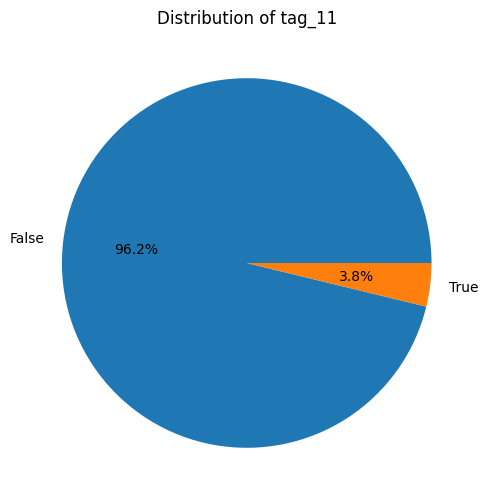

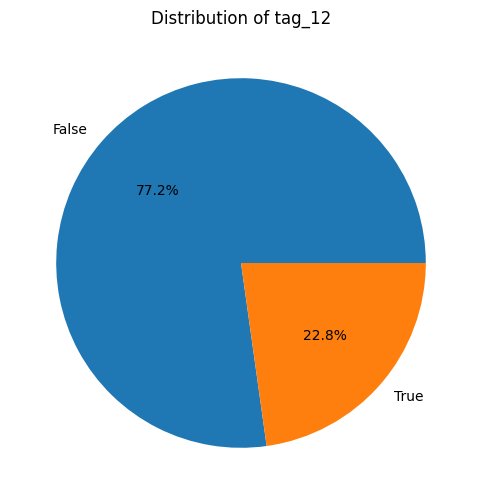

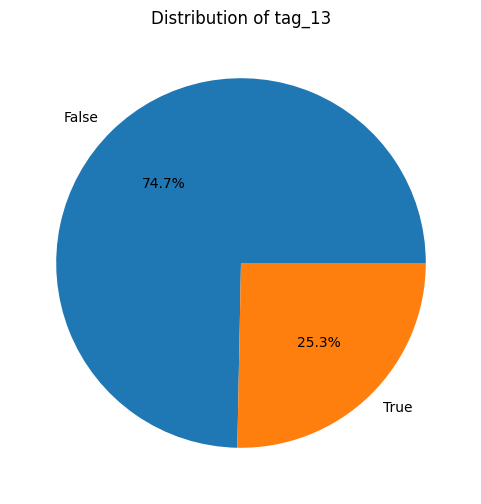

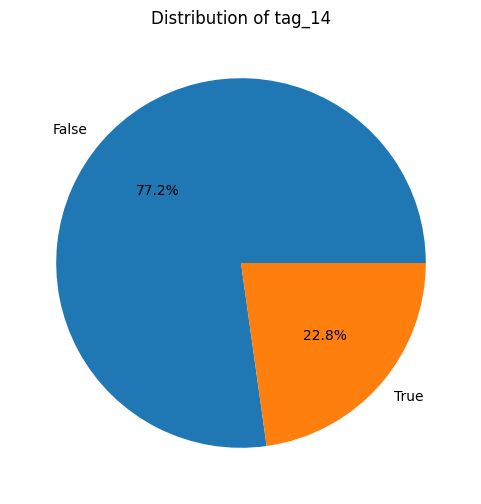

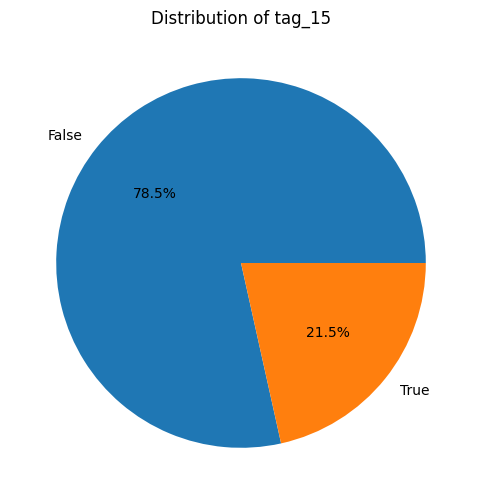

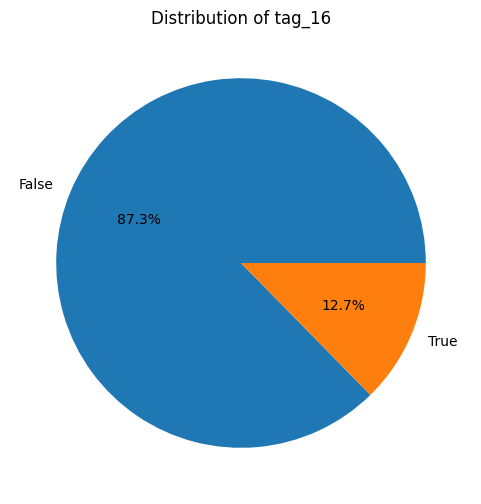


Responders Dataset Shape: (9, 6)

Missing Values:
 responder    0
tag_0        0
tag_1        0
tag_2        0
tag_3        0
tag_4        0
dtype: int64

Summary Statistics:
        responder
count   9.000000
mean    4.000000
std     2.738613
min     0.000000
25%     2.000000
50%     4.000000
75%     6.000000
max     8.000000


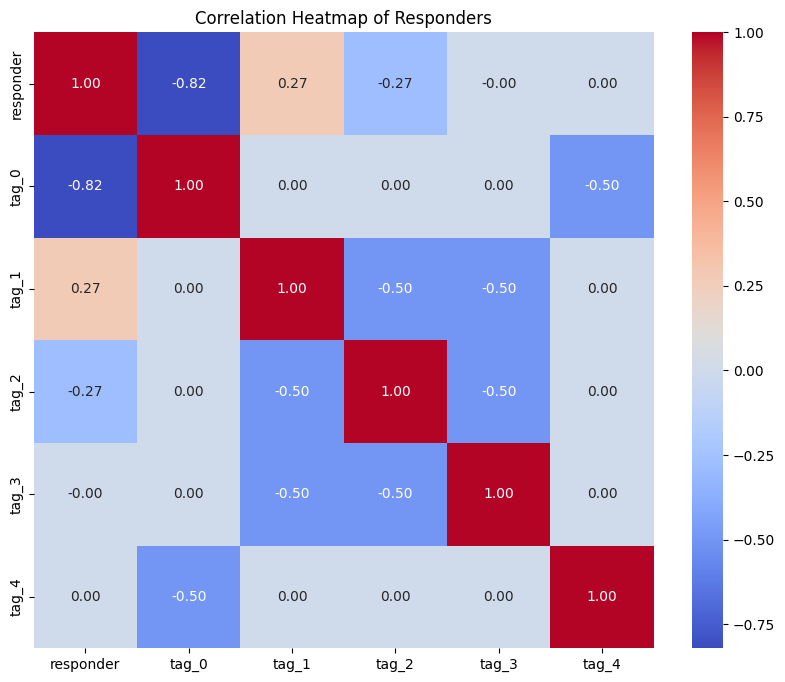

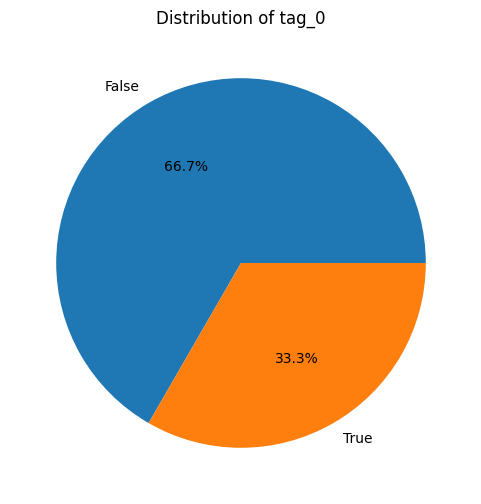

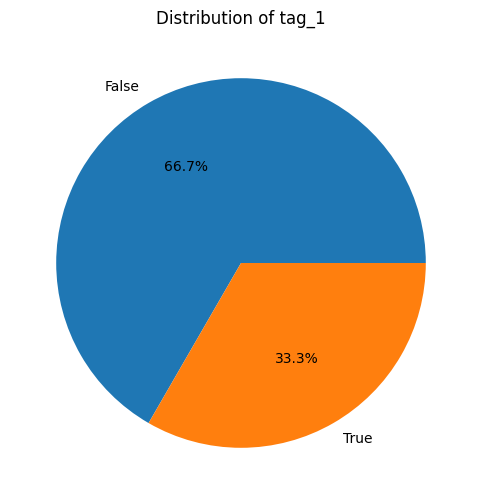

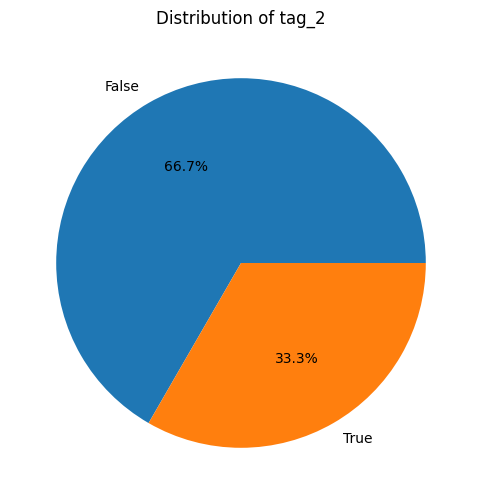

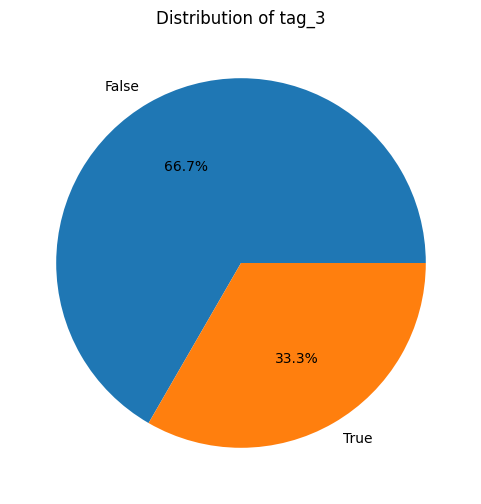

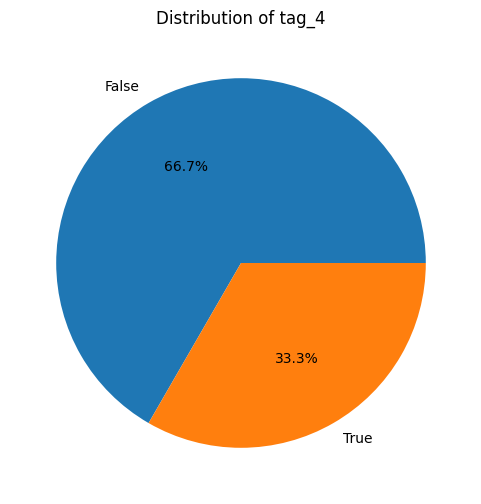

In [6]:
def perform_eda(df, name):
    print(f"\n{name} Dataset Shape: {df.shape}")
    print("\nMissing Values:\n", df.isnull().sum().sort_values(ascending=False))
    print("\nSummary Statistics:\n", df.describe())
    
    # correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap of {name}')
    plt.show()
    
    # pie chart for categorical variables
    cat_cols = df.select_dtypes(include=['object', 'bool']).columns
    for col in cat_cols:
        plt.figure(figsize=(6, 6))
        df[col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f'Distribution of {col}')
        plt.ylabel('')
        plt.show()

perform_eda(features_data, "Features")
perform_eda(responders_data, "Responders")

# Converting Categorical Features Using Label Encoding

In [7]:
labelencoder = LabelEncoder()
for col in features_data.columns:
    features_data[col] = labelencoder.fit_transform(features_data[col])
for col in responders_data.columns:
    responders_data[col] = labelencoder.fit_transform(responders_data[col])

# Defining Target Variable and Features

In [8]:
X = train_data.drop(['partition_id', 'responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4',
                     'responder_5', 'responder_6', 'responder_7', 'responder_8'])
y = train_data['responder_6']

In [9]:
X_sample = X.sample(fraction=0.1, seed=42)
sample_indices = X_sample.get_column('date_id').to_numpy().astype(int)
y_sample=y[sample_indices]

In [10]:
X_sample_pd = X_sample.to_pandas()
y_sample_pd = y_sample.to_pandas()
y_sample_pd.head()

0    0.325985
1    0.426576
2    0.197496
3    0.730779
4    0.611497
Name: responder_6, dtype: float32

# Preprocessors

In [11]:
numeric_features = X_sample_pd.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_sample_pd.select_dtypes(exclude=[np.number]).columns.tolist()

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
]) 

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model Pipeline

In [13]:
params={'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 200,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":33,
        'max_depth': 14,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LGBMRegressor(**params))
])


# Train-Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_pd, y_sample_pd, test_size=0.2, random_state=42)

# Preprocessing

In [15]:
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Train Model 

In [16]:
model = LGBMRegressor(**params, n_estimators=1000)
model.fit(
    X_train_transformed, y_train, 
    eval_set=[(X_test_transformed, y_test)], 
    eval_metric='rmse', 
)

[LightGBM] [Warning] feature_fraction is set=0.686612409641711, colsample_bytree=0.99 will be ignored. Current value: feature_fraction=0.686612409641711
[LightGBM] [Warning] lambda_l2 is set=0.02085548700474218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02085548700474218
[LightGBM] [Warning] lambda_l1 is set=0.004107624022751344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004107624022751344
[LightGBM] [Warning] bagging_fraction is set=0.7934712636944741, subsample=0.99 will be ignored. Current value: bagging_fraction=0.7934712636944741
[LightGBM] [Warning] feature_fraction is set=0.686612409641711, colsample_bytree=0.99 will be ignored. Current value: feature_fraction=0.686612409641711
[LightGBM] [Warning] lambda_l2 is set=0.02085548700474218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02085548700474218
[LightGBM] [Warning] lambda_l1 is set=0.004107624022751344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004107624022751344


LGBMRegressor(bagging_fraction=0.7934712636944741, colsample_bytree=0.99,
              feature_fraction=0.686612409641711,
              lambda_l1=0.004107624022751344, lambda_l2=0.02085548700474218,
              learning_rate=0.05, max_depth=14, metric='rmse',
              min_child_samples=21, n_estimators=1000, num_leaves=200,
              objective='regression', random_state=33, subsample=0.99,
              verbose=1)

In [17]:
pipeline.named_steps['model'] = model

# Model Evaluation

In [18]:
pipeline.named_steps['model'].fit(X_train_transformed, y_train)
predictions = pipeline.named_steps['model'].predict(X_test_transformed)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}\nRMSE: {rmse}\nR2 Score: {r2}")

[LightGBM] [Warning] feature_fraction is set=0.686612409641711, colsample_bytree=0.99 will be ignored. Current value: feature_fraction=0.686612409641711
[LightGBM] [Warning] lambda_l2 is set=0.02085548700474218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02085548700474218
[LightGBM] [Warning] lambda_l1 is set=0.004107624022751344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004107624022751344
[LightGBM] [Warning] bagging_fraction is set=0.7934712636944741, subsample=0.99 will be ignored. Current value: bagging_fraction=0.7934712636944741
[LightGBM] [Warning] feature_fraction is set=0.686612409641711, colsample_bytree=0.99 will be ignored. Current value: feature_fraction=0.686612409641711
[LightGBM] [Warning] lambda_l2 is set=0.02085548700474218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02085548700474218
[LightGBM] [Warning] lambda_l1 is set=0.004107624022751344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004107624022751344


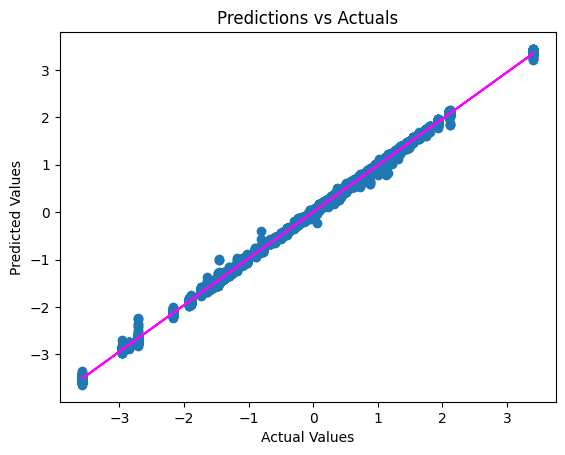

In [19]:
# Plot Predictions
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actuals')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()
